# 2 Задание

In [88]:
from PIL import Image
from matplotlib.pyplot import figure, imshow, show
import numpy as np

def get_image() -> np.array:
    dir = "images/"
    image = Image.open(dir + "example.png")
    image_array = np.array(image)[:, :, :3]
    return image_array


def show_image(array: np.array):
    figure()
    imshow(array, cmap='Greys')
   

# show_image(get_image())

## Полутоновое изображение

In [89]:
def get_halftone_image() -> np.array:
    image_array = get_image()
    mean = np.mean(image_array, axis=2, dtype=int)
    return mean

## Шум

In [90]:
import random


def get_noise_image(mean: float = 50, sigma: float = 5, data_type=float) -> np.array:
    halftone_image_array = get_halftone_image()
    return np.clip(np.array([np.array([pixel + random.gauss(mean, sigma) * random.randint(0, 1) // 3 for pixel in row], dtype=data_type)
                     for row in halftone_image_array]), 0, 255)

# show_image(get_noise_image())

## Гистограмма

In [91]:
from collections import Counter

from matplotlib.pyplot import bar
import numpy.typing as npt


def get_hist(data: npt.NDArray[int]) -> npt.NDArray[int]:
    cnt = Counter(data.reshape(-1))
    y = np.array([cnt.get(el, 0) for el in range(256)])
    return y


def draw_hist(data: npt.NDArray[int]):
    x = list(range(256))
    y = get_hist(data)
    bar(x, y)

# noise_appended_array = get_noise_image(data_type=int)
# draw_hist(get_halftone_image())

## Размытие Гаусса

In [92]:
def image_filter(K_size, sigma, im):
    H, W = im.shape
    
    pad = K_size // 2
    out = np.zeros((H + pad * 2, W + pad * 2), np.float64)
    out[pad: pad + H, pad: pad + W] = im.copy().astype(np.float64)

    K = np.zeros((K_size, K_size), np.float64)
    for x in range(-pad, -pad + K_size):
        for y in range(-pad, -pad + K_size):
            K[x + pad, y + pad] = np.exp( -(x * x + y * y) / (2 * (sigma * sigma)))
    K /= 2 * np.pi * sigma * sigma
    K /= K.sum()
 
    tmp = out.copy()
  
    for y in range(H):
        for x in range(W):
            out[pad + y, pad + x] = np.sum(K * tmp[y: y + K_size, x: x + K_size])
    out = np.clip(out, 0, 255).astype(np.uint)
    return out[pad: pad + H, pad: pad + W]

## Бинаризация изображения

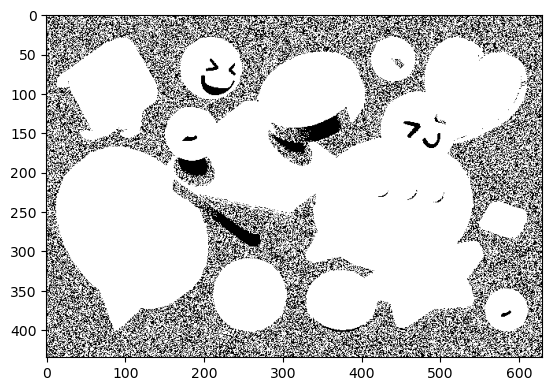

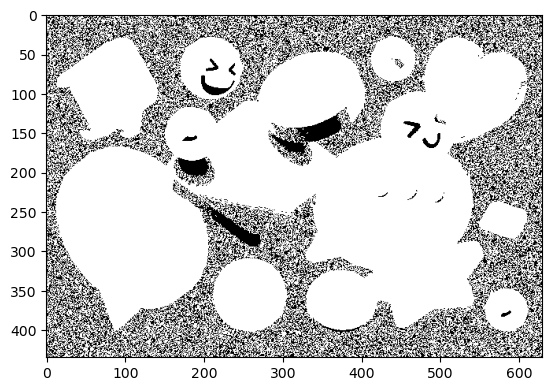

In [93]:
def otsu_algorithm(hist: npt.NDArray[int], t: int):
    T = u = t
    s_max = 0
    freq = np.cumsum(hist)
    while u < 255:
        q1 = freq[u]
        q2 = freq[255] - freq[u]
        mub = np.mean(hist[:u])
        muf = np.mean(hist[u:])
        dw = q1 * q2 * (mub - muf) ** 2
        if dw > s_max:
            s_max = dw
            T = u
        u += t
    return T


def salt_and_pepper_filter(image):
    H, W = image.shape

    out = np.ones((H + 2, W + 2), np.float64)
    out[1: 1 + H, 1: 1 + W] = image.copy().astype(np.uint8)

    salt_mask = np.zeros((3, 3), np.uint8)
    salt_mask[1, 1] = 1
    pepper_mask = np.ones((3, 3), np.uint8)
    pepper_mask[1, 1] = 0
    for y in range(H):
        for x in range(W):
            if np.array_equal(out[y: y + 3, x: x + 3], salt_mask):
                out[y + 1, x + 1] = 0
            elif np.array_equal(out[y: y + 3, x: x + 3], pepper_mask):
                out[y + 1, x + 1] = 1
    return out[1: 1 + H, 1: 1 + W]


def get_binary_image():
    # image = image_filter(10, 2.8, get_noise_image())
    # image = get_halftone_image()
    image = get_noise_image()
    t = otsu_algorithm(get_hist(image), 1)
    image[image <= t] = t
    image[image > t] = 0
    image[image == t] = 1
    return salt_and_pepper_filter(image)

show_image(get_binary_image())

## Разрастание областей с семянами

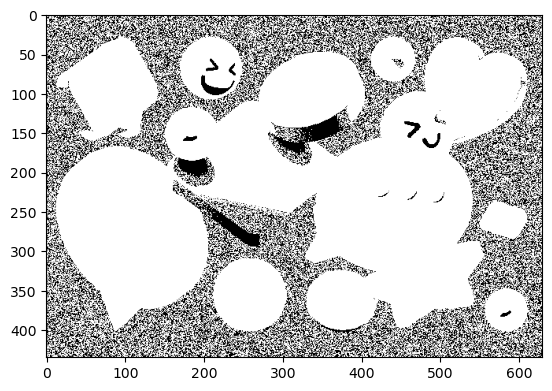

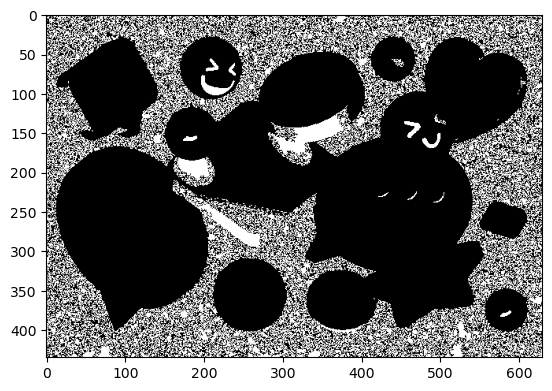

In [95]:
from typing import Tuple, List


def region_growth(bin_img: npt.NDArray[np.int8], seeds: List[Tuple[int, int]]) -> npt.NDArray:
    result_img = np.zeros(bin_img.shape, dtype=np.uint8)
    directs = [(-1,-1), (0,-1), (1,-1), (1,0), (1,1), (0,1), (-1,1), (-1,0)]
    for seed in seeds:
        result_img[seed[1], seed[0]] = 1
    visited = np.zeros(bin_img.shape, dtype=np.uint8)
    while seeds:
        seed = seeds.pop(0)
        visited[seed[1], seed[0]] = 1
        for direct in directs:
            x = seed[0] + direct[0]
            y = seed[1] + direct[1]
            if x < 0 or y < 0 or x >= bin_img.shape[1] or y >= bin_img.shape[0]:
                continue
            if not visited[y, x] and bin_img[y, x] == bin_img[seed[1], seed[0]]:
                result_img[y, x] = 1
                visited[y, x] = 1
                seeds.append((x, y))
    return result_img

show_image(region_growth(get_binary_image(), [(100, 100)]))

## Гистограмный метод